Beta = 1.237659769341553


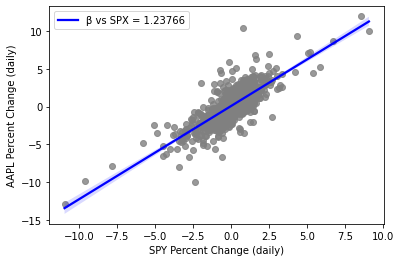

In [4]:
import requests
import os
import json
import datetime

import seaborn as sns
import pandas as pd
import numpy as np
from scipy import stats

from dotenv import load_dotenv

load_dotenv() #Loads Tiingo API Token from .env file

API_TOKEN = os.getenv('TIINGO_TOKEN')

#https://api.tiingo.com/tiingo/daily/<ticker>/prices?startDate=2012-1-1&endDate=2016-1-1 

def fetch_metadata(ticker):
    metadata_response = requests.get('https://api.tiingo.com/tiingo/daily/{tkr}?token={token}'.format(tkr=ticker, token=API_TOKEN))

    response_json = json.loads(metadata_response.content)
    #print(response_json.keys())
    print('data available from {0} to {1}'.format(response_json['startDate'], response_json['endDate']))
    #TODO: check dates

#fetch_metadata('BRK-B')

def beta(ticker='AAPL'):
    #try to go back 5yrs
    _today = datetime.date.today()
    five_yrs_ago = datetime.date(_today.year - 5, _today.month, _today.day)
    #TODO: find a better way to do this?

    #print(_today, five_yrs_ago)

    #No ticker parameter here; this is SPY data to compare against
    spy_response = requests.get(
        'https://api.tiingo.com/tiingo/daily/SPY/prices?startDate={start}&endDate={end}&token={token}&format=csv'
        .format(
            start=five_yrs_ago,
            end=_today,
            token=API_TOKEN
        )
    )
    with open('data/SPY.csv', 'wb') as spy:
        spy.write(spy_response.content)

    #TODO: check for file existing?
    ticker_response = requests.get(
        'https://api.tiingo.com/tiingo/daily/{ticker}/prices?startDate={start}&endDate={end}&token={token}&format=csv'
        .format(
            ticker=ticker,
            start=five_yrs_ago,
            end=_today,
            token=API_TOKEN
        )
    )
    with open('data/{0}.csv'.format(ticker), 'wb') as f:
        f.write(ticker_response.content)

    df = pd.read_csv('data/{0}.csv'.format(ticker))
    df2 = pd.read_csv('data/SPY.csv')

    df = pd.merge(df, df2, on='date', suffixes=('_{0}'.format(ticker), '_SPY'))
    #Merge SPY data into ticker

    #print(df[['date', 'adjClose_AAPL', 'adjClose_SPY']].tail())

    pct_returns = df[['adjClose_SPY', 'adjClose_{0}'.format(ticker)]].pct_change() * 100
    pct_returns.rename(columns={'adjClose_SPY': 'SPY%', 'adjClose_{0}'.format(ticker): '{0}%'.format(ticker)}, inplace=True)
    #print(pct_returns)
    
    pct_returns = pct_returns.iloc[1:,:] #take off first row (NaN)

    slope, intercept, r_val, p_val, std_err = stats.linregress(pct_returns['SPY%'], pct_returns['{0}%'.format(ticker)])
    print("Beta = {0}".format(slope))

    ax = sns.regplot(
        data=pct_returns,
        x='SPY%',
        y='{}%'.format(ticker),
        color='gray',
        line_kws={'label': "β vs SPX = {0:.5f}".format(slope), 'color': 'blue'}
    )

    ax.set_xlabel("SPY Percent Change (daily)")
    ax.set_ylabel("{0} Percent Change (daily)".format(ticker))
    ax.legend()

    #TODO: add option for Monthly beta
    

beta('AAPL')